In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.tsa.api as smt
import statsmodels.api as sm

from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_absolute_error
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt

%matplotlib inline

In [2]:
sns.set()

df = pd.read_csv("../../data/datasets_modal_spx_train.csv")
df_test = pd.read_csv("../../data/datasets_modal_spx_test.csv")

In [3]:
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def plot_moving_average(series, window, plot_intervals=False, scale=1.96):

    rolling_mean = series.rolling(window=window).mean()
    
    plt.figure(figsize=(17,8))
    plt.title('Moving average\n window size = {}'.format(window))
    plt.plot(rolling_mean, 'g', label='Rolling mean trend')
    
    #Plot confidence intervals for smoothed values
    if plot_intervals:
        mae = mean_absolute_error(series[window:], rolling_mean[window:])
        deviation = np.std(series[window:] - rolling_mean[window:])
        lower_bound = rolling_mean - (mae + scale * deviation)
        upper_bound = rolling_mean + (mae + scale * deviation)
        plt.plot(upper_bound, 'r--', label='Upper bound / Lower bound')
        plt.plot(lower_bound, 'r--')
            
    plt.plot(series[window:], label='Actual values')
    plt.legend(loc='best')
    plt.grid(True)
    
def tsplot(y, lags=None, figsize=(12, 7), syle='bmh'):
    
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style='bmh'):
        fig = plt.figure(figsize=figsize)
        layout = (2,2)
        ts_ax = plt.subplot2grid(layout, (0,0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1,0))
        pacf_ax = plt.subplot2grid(layout, (1,1))
        
        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()

In [4]:
df_train = df
df_train["date"] = pd.to_datetime(df_train["date"])
df_train['day of month'] = pd.DatetimeIndex(df_train["date"]).day
df_train['day of week'] = pd.DatetimeIndex(df_train["date"]).dayofweek
df_train['month'] = pd.DatetimeIndex(df_train["date"]).month
df_train['year'] = pd.DatetimeIndex(df_train["date"]).year
df_train = df_train.set_index('date')
df_train.head()

,close,day of month,day of week,month,year
date,,,,,
1986-01-02,209.59,2,3,1,1986
1986-01-03,210.88,3,4,1,1986
1986-01-06,210.65,6,0,1,1986
1986-01-07,213.80,7,1,1,1986
1986-01-08,207.97,8,2,1,1986


In [5]:
df_train_week = df
df_train_week["date"] = pd.to_datetime(df_train_week["date"])
df_train_week = df_train_week.groupby([pd.Grouper(key='date', freq='W-SUN')])['close'].mean().reset_index()
df_train_week['month'] = pd.DatetimeIndex(df_train_week["date"]).month
df_train_week['year'] = pd.DatetimeIndex(df_train_week["date"]).year
df_train_week = df_train_week.set_index('date')
df_train_week.head()

,close,month,year
date,,,
1986-01-05,210.235,1,1986
1986-01-12,208.898,1,1986
1986-01-19,207.844,1,1986
1986-01-26,205.498,1,1986
1986-02-02,209.720,2,1986


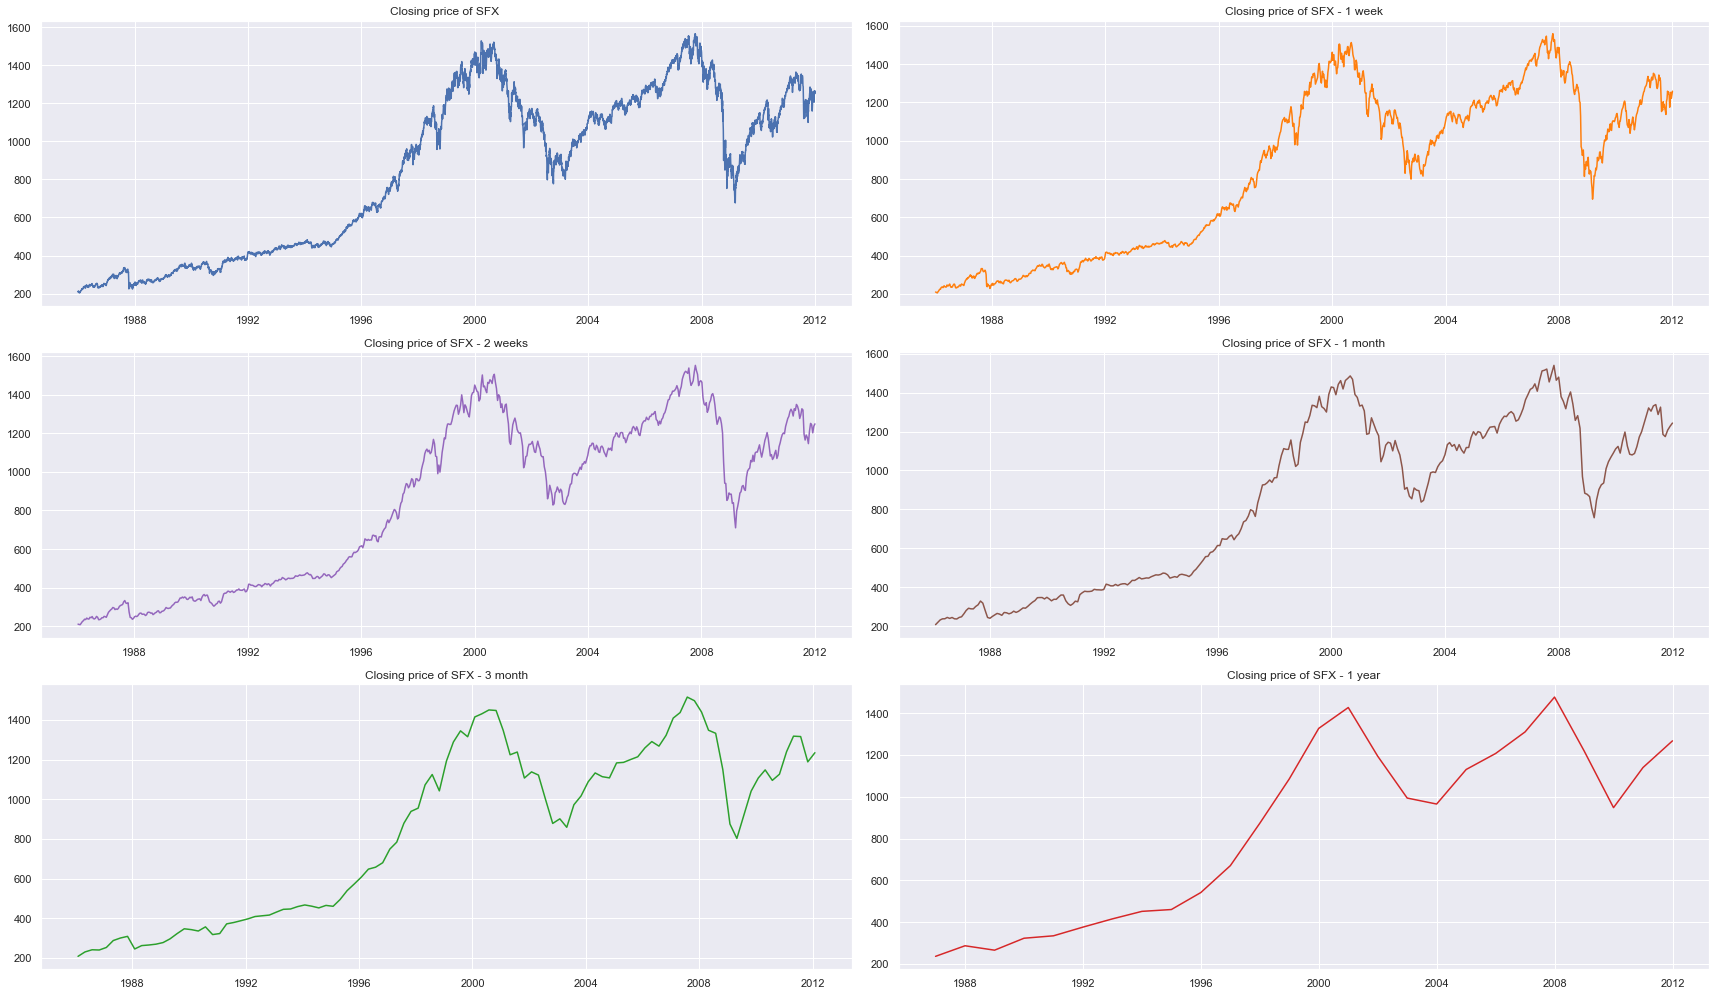

In [6]:
#2 weeks table
df_train_2_week = df
df_train_2_week["date"] = pd.to_datetime(df_train_2_week["date"])
df_train_2_week = df_train_2_week.groupby([pd.Grouper(key='date', freq='2W-SUN')])['close'].mean().reset_index()
df_train_2_week = df_train_2_week.set_index('date')

#month table
df_train_month = df
df_train_month["date"] = pd.to_datetime(df_train_month["date"])
df_train_month = df_train_month.groupby([pd.Grouper(key='date', freq='M')])['close'].mean().reset_index()
df_train_month = df_train_month.set_index('date')

#3 month table
df_train_3_month = df
df_train_3_month["date"] = pd.to_datetime(df_train_3_month["date"])
df_train_3_month = df_train_3_month.groupby([pd.Grouper(key='date', freq='3M')])['close'].mean().reset_index()
df_train_3_month = df_train_3_month.set_index('date')

#year table
df_train_year = df
df_train_year["date"] = pd.to_datetime(df_train_year["date"])
df_train_year = df_train_year.groupby([pd.Grouper(key='date', freq='Y')])['close'].mean().reset_index()
df_train_year = df_train_year.set_index('date')

#Printing the tables
fig, axs = plt.subplots(3, 2, figsize=(24, 14))
axs[0, 0].plot(df_train.close)
axs[0, 0].set_title('Closing price of SFX ')
axs[0, 1].plot(df_train_week.close, 'tab:orange')
axs[0, 1].set_title('Closing price of SFX - 1 week')
axs[1, 0].plot(df_train_2_week.close, 'tab:purple')
axs[1, 0].set_title('Closing price of SFX - 2 weeks')
axs[1, 1].plot(df_train_month.close, 'tab:brown')
axs[1, 1].set_title('Closing price of SFX - 1 month')
axs[2, 0].plot(df_train_3_month.close, 'tab:green')
axs[2, 0].set_title('Closing price of SFX - 3 month')
axs[2, 1].plot(df_train_year.close, 'tab:red')
axs[2, 1].set_title('Closing price of SFX - 1 year')
fig.tight_layout()

Text(0, 0.5, 'Close price')

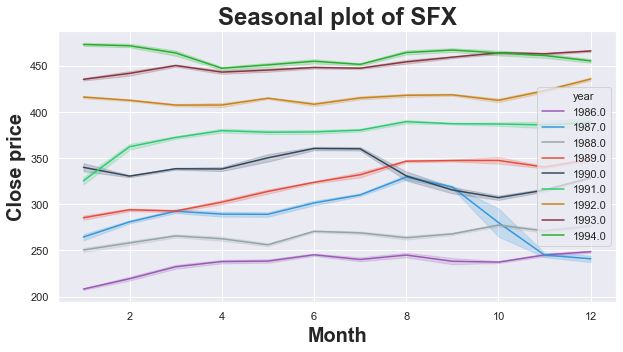

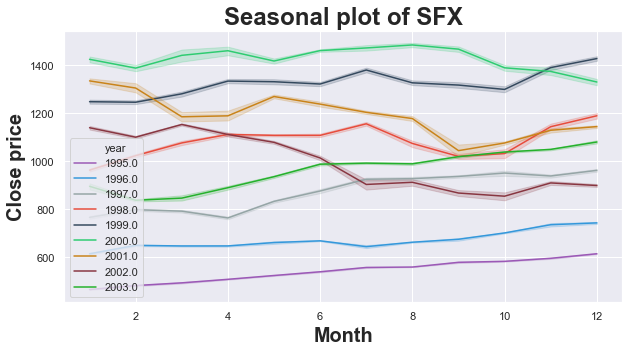

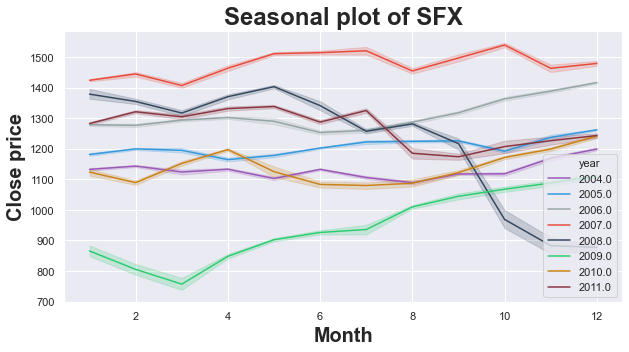

In [7]:
#Printing 1986-1994 Seasonal plot
fig, ax = plt.subplots(figsize=(10, 5))
flatui = ["#9b59b6", "#3498db", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71","#c98319","#883641",'#24b12b']
palette = sns.color_palette(flatui, 9)
sns.lineplot(df_train['month'], df_train['close'], hue=df_train['year']['1986':'1994'], palette=palette)
ax.set_title('Seasonal plot of SFX', fontsize = 24, loc='center', fontdict=dict(weight='bold'))
ax.set_xlabel('Month', fontsize = 20, fontdict=dict(weight='bold'))
ax.set_ylabel('Close price', fontsize = 20, fontdict=dict(weight='bold')) 

#Printing 1995-2003 Seasonal plot
fig, ax1 = plt.subplots(figsize=(10, 5))
sns.lineplot(df_train['month'], df_train['close'], hue=df_train['year']['1995':'2003'], palette=palette)
ax1.set_title('Seasonal plot of SFX', fontsize = 24, loc='center', fontdict=dict(weight='bold'))
ax1.set_xlabel('Month', fontsize = 20, fontdict=dict(weight='bold'))
ax1.set_ylabel('Close price', fontsize = 20, fontdict=dict(weight='bold')) 

#Printing 2004-2011 Seasonal plot
fig, ax2 = plt.subplots(figsize=(10, 5))
palette = sns.color_palette(flatui, 8)
sns.lineplot(df_train['month'], df_train['close'], hue=df_train['year']['2004':'2011'], palette=palette)
ax2.set_title('Seasonal plot of SFX', fontsize = 24, loc='center', fontdict=dict(weight='bold'))
ax2.set_xlabel('Month', fontsize = 20, fontdict=dict(weight='bold'))
ax2.set_ylabel('Close price', fontsize = 20, fontdict=dict(weight='bold')) 

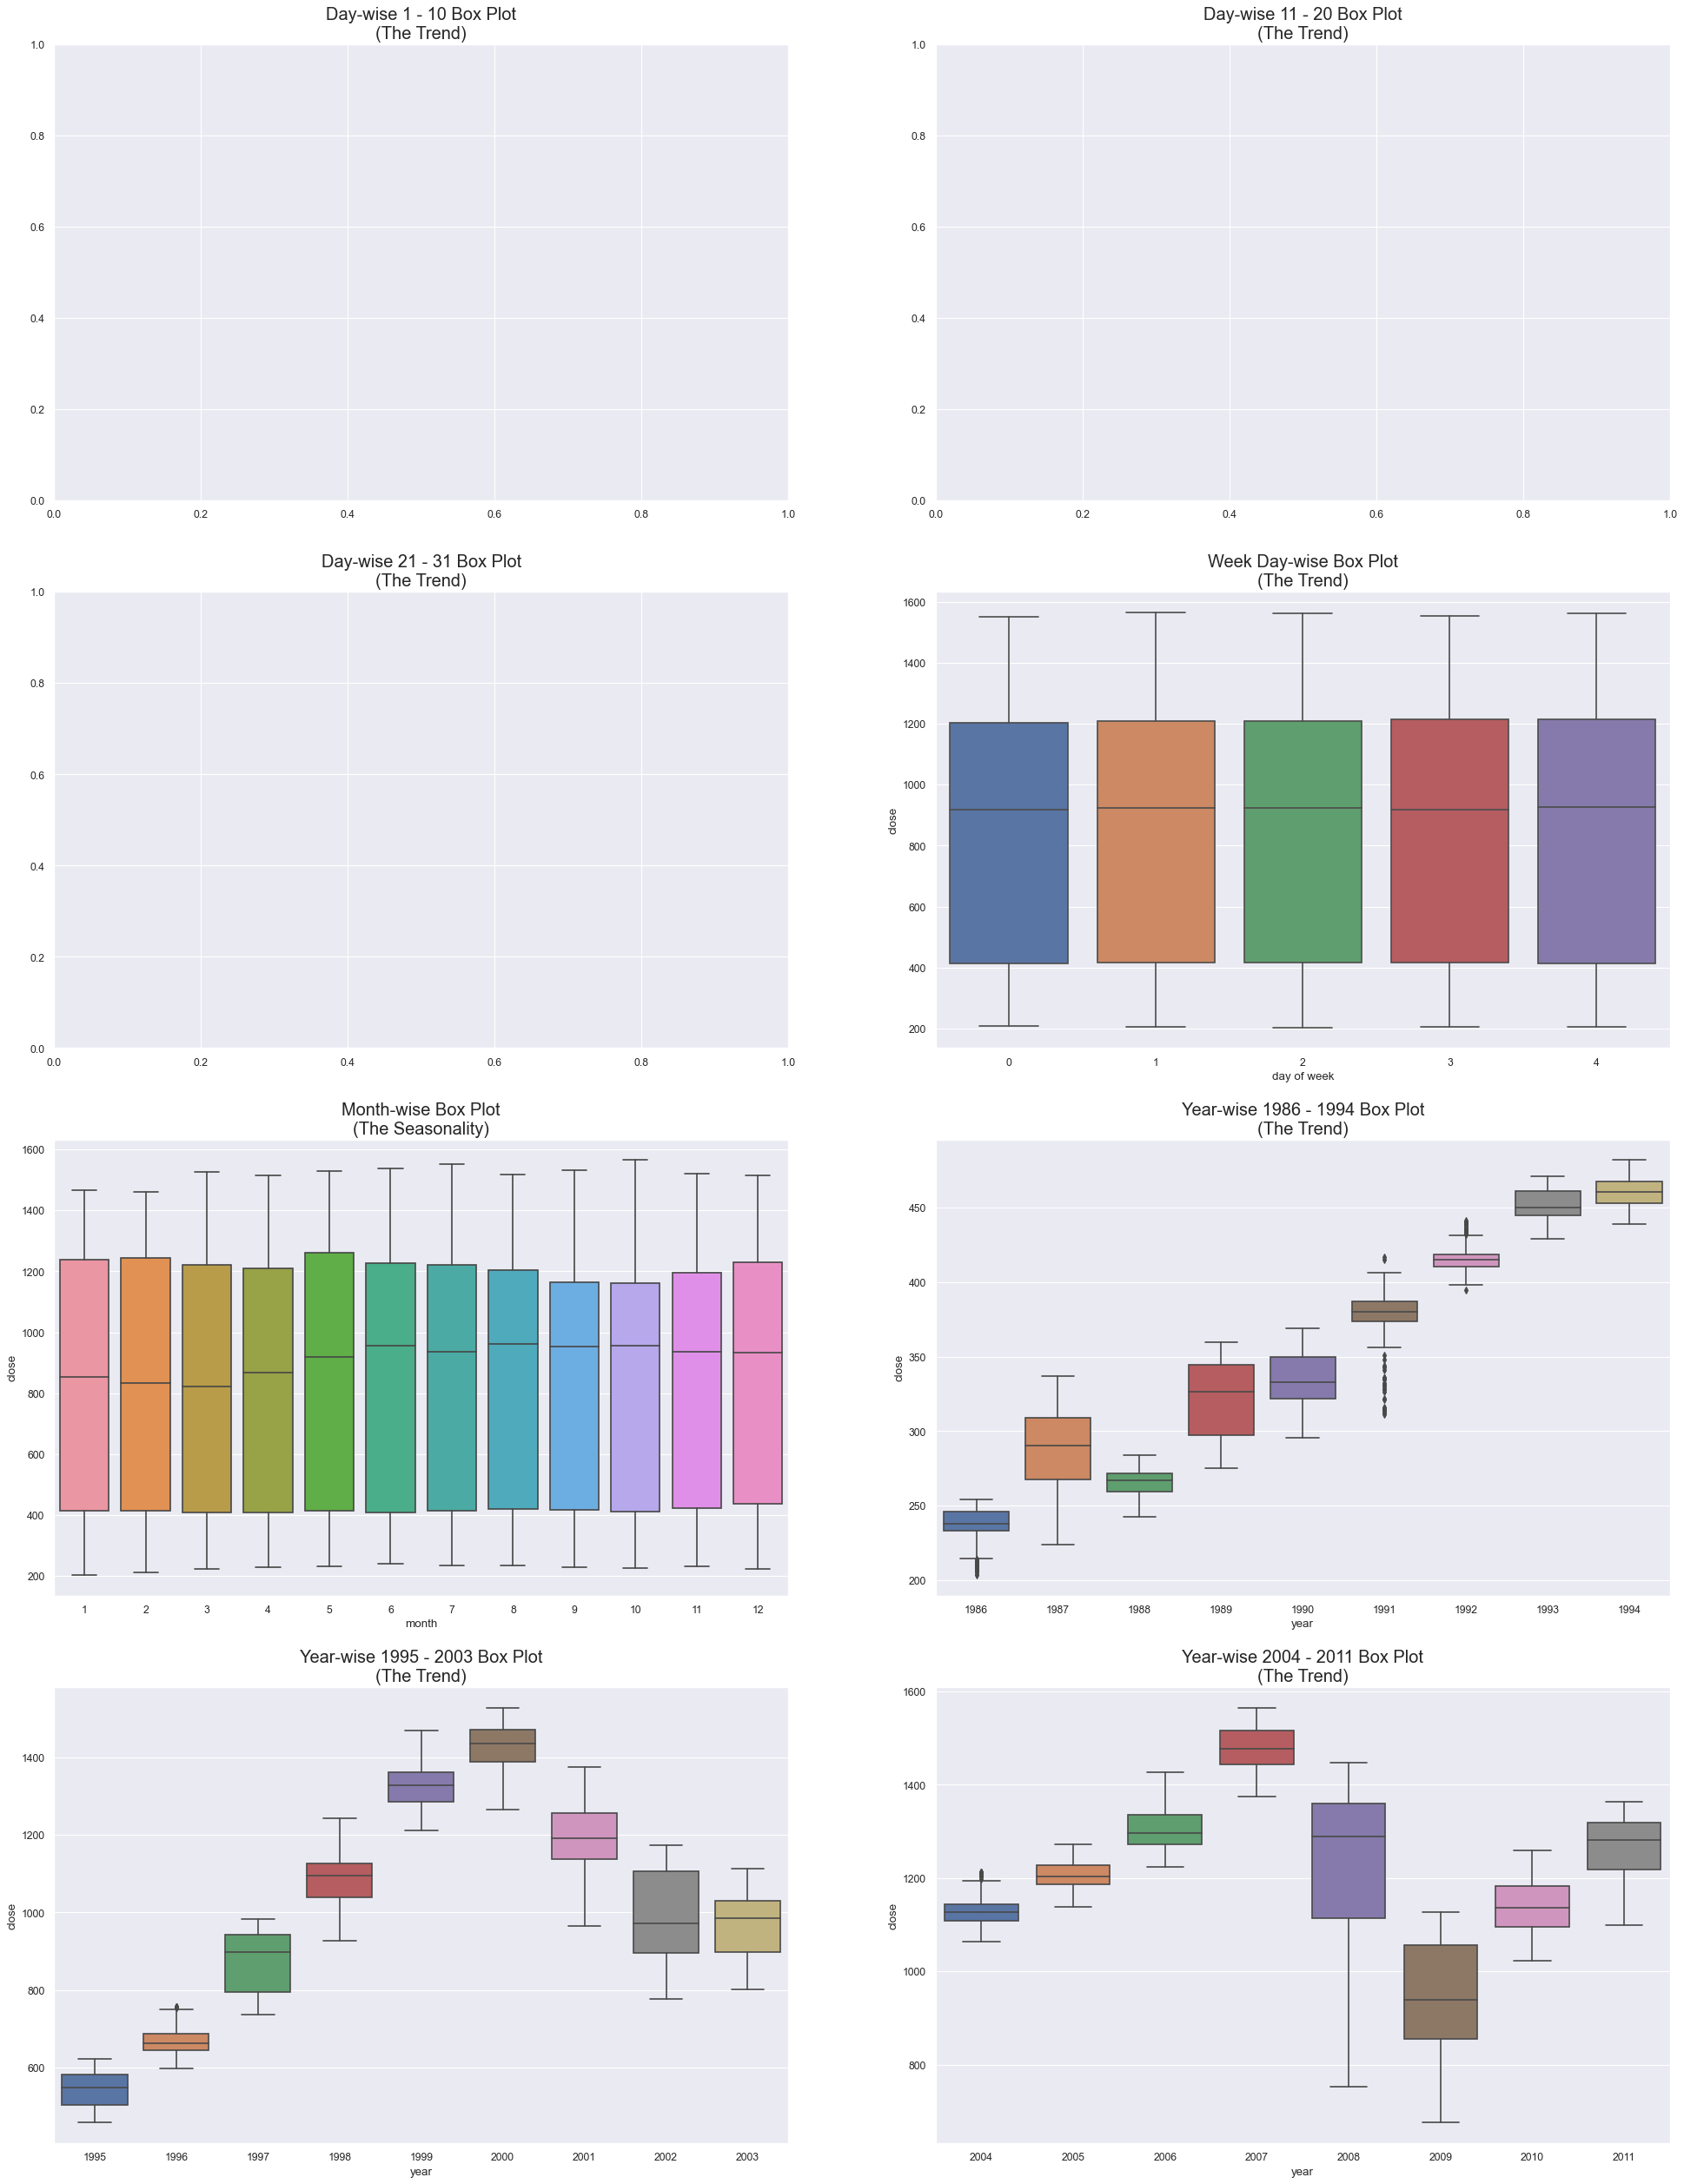

In [8]:
# Draw Plot
fig, axes = plt.subplots(4, 2, figsize=(30,40), dpi= 80)
#sns.boxplot(x='day', y='close', data=df_train['1':'15'], ax=axes[0,0])
#sns.boxplot(x='day', y='close', data=df_train['day'][11:20], ax=axes[0,1])
#sns.boxplot(x='day', y='close', data=df_train['day'][21:31], ax=axes[1,0])
sns.boxplot(x='day of week', y='close', data=df_train, ax=axes[1,1])
sns.boxplot(x='month', y='close', data=df_train, ax=axes[2,0])
sns.boxplot(x='year', y='close', data=df_train['1986':'1994'], ax=axes[2,1])
sns.boxplot(x='year', y='close', data=df_train['1995':'2003'], ax=axes[3,0])
sns.boxplot(x='year', y='close', data=df_train['2004':'2011'], ax=axes[3,1])


# Set Title
axes[0,0].set_title('Day-wise 1 - 10 Box Plot\n(The Trend)', fontsize=18);
axes[0,1].set_title('Day-wise 11 - 20 Box Plot\n(The Trend)', fontsize=18);
axes[1,0].set_title('Day-wise 21 - 31 Box Plot\n(The Trend)', fontsize=18);
axes[1,1].set_title('Week Day-wise Box Plot\n(The Trend)', fontsize=18);
axes[2,0].set_title('Month-wise Box Plot\n(The Seasonality)', fontsize=18)
axes[2,1].set_title('Year-wise 1986 - 1994 Box Plot\n(The Trend)', fontsize=18);
axes[3,0].set_title('Year-wise 1995 - 2003 Box Plot\n(The Trend)', fontsize=18);
axes[3,1].set_title('Year-wise 2004 - 2011 Box Plot\n(The Trend)', fontsize=18);

plt.show()

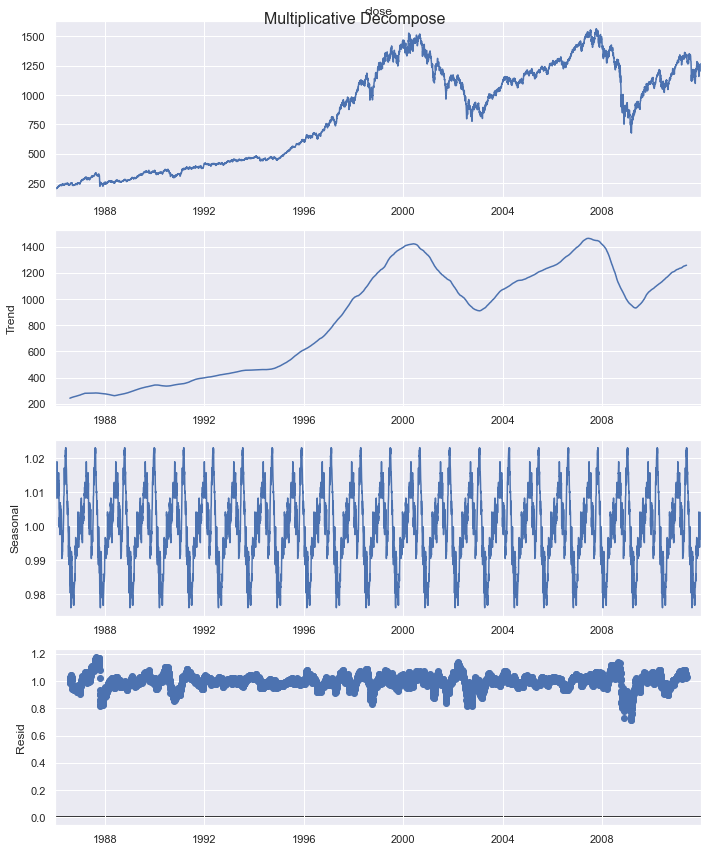

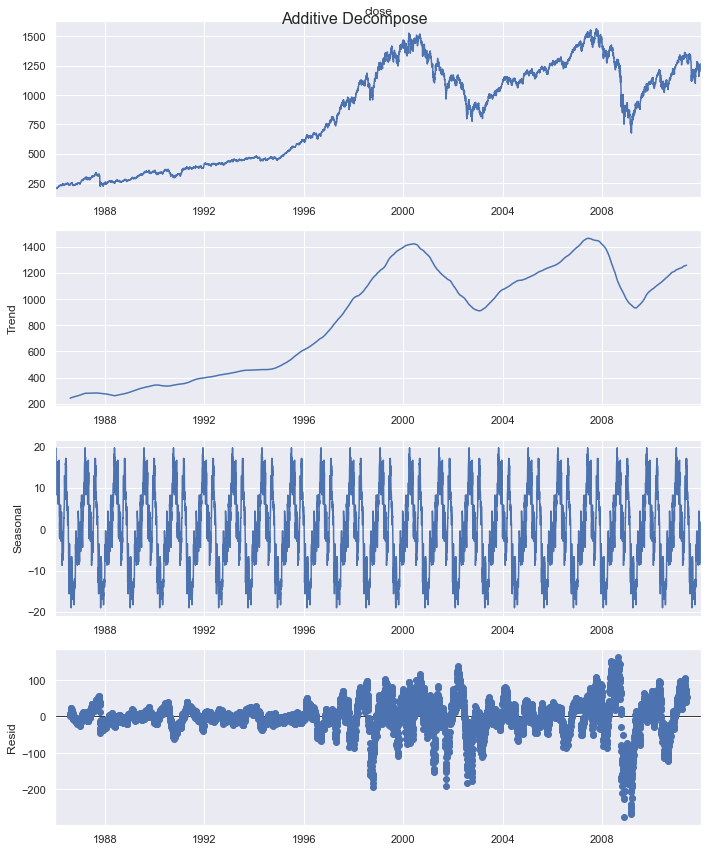

In [9]:
# Multiplicative Decomposition 
result_mul = seasonal_decompose(df_train['close'], model='multiplicative', period = 300)

# Additive Decomposition
result_add = seasonal_decompose(df_train['close'], model='additive', period = 300)

# Plot
plt.rcParams.update({'figure.figsize': (10,12)})
result_mul.plot().suptitle('Multiplicative Decompose', fontsize=16)
result_add.plot().suptitle('Additive Decompose', fontsize=16)
plt.show()

# Parte 2 - Previsões

In [10]:
df_test["date"] = pd.to_datetime(df_test["date"])
df_test = df_test.set_index('date')

df_train_2 = df
df_train_2["date"] = pd.to_datetime(df_train_2["date"])
df_train_2 = df_train_2.groupby([pd.Grouper(key='date', freq='W-SUN')])['close'].mean().reset_index()
df_train_2 = df_train_2.set_index('date')

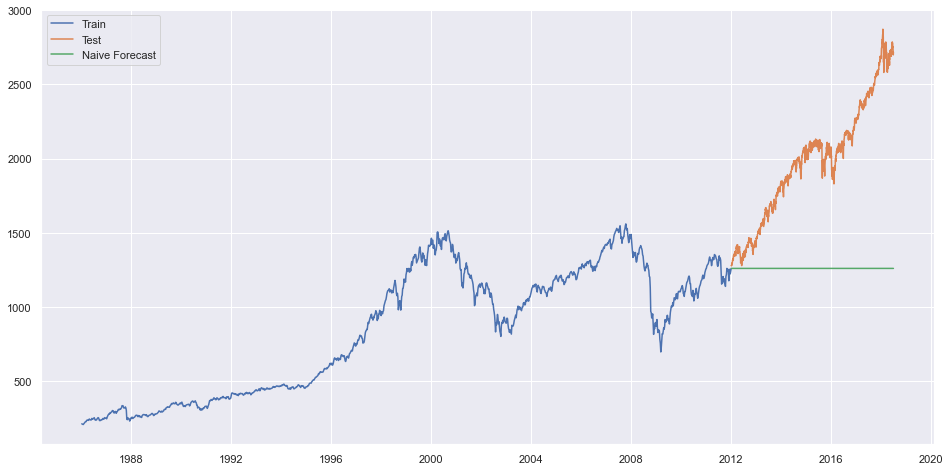

In [11]:
dd= np.asarray(df_train_2.close)
y_hat = df_test.copy()
y_hat['naive'] = dd[len(dd)-1]
plt.figure(figsize=(16,8))
plt.plot(df_train_2.index, df_train_2['close'], label='Train')
plt.plot(df_test.index,df_test['close'], label='Test')
plt.plot(y_hat.index,y_hat['naive'], label='Naive Forecast')
plt.legend(loc='best')
plt.show()

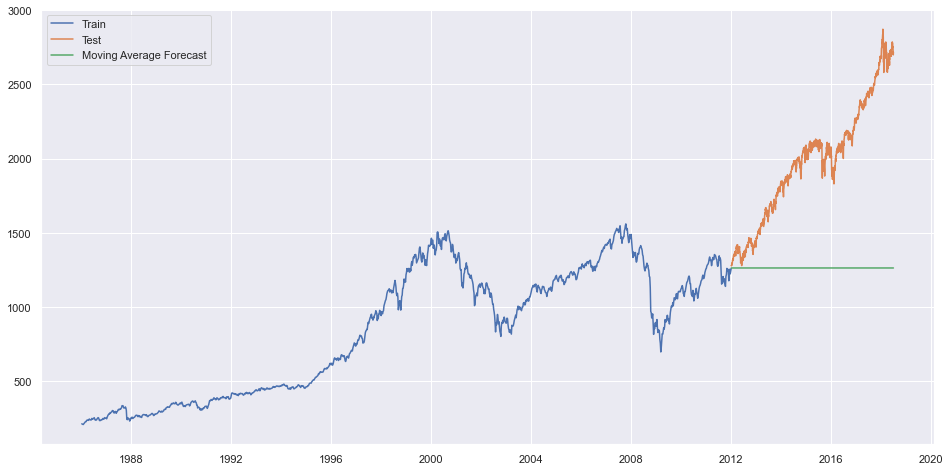

In [25]:
y_hat_avg = df_test.copy()
y_hat_avg['moving_avg_forecast'] = df_train_2['close'].rolling(60).mean().iloc[-1]
plt.figure(figsize=(16,8))
plt.plot(df_train_2['close'], label='Train')
plt.plot(df_test['close'], label='Test')
plt.plot(y_hat_avg['moving_avg_forecast'], label='Moving Average Forecast')
plt.legend(loc='best')
plt.show()

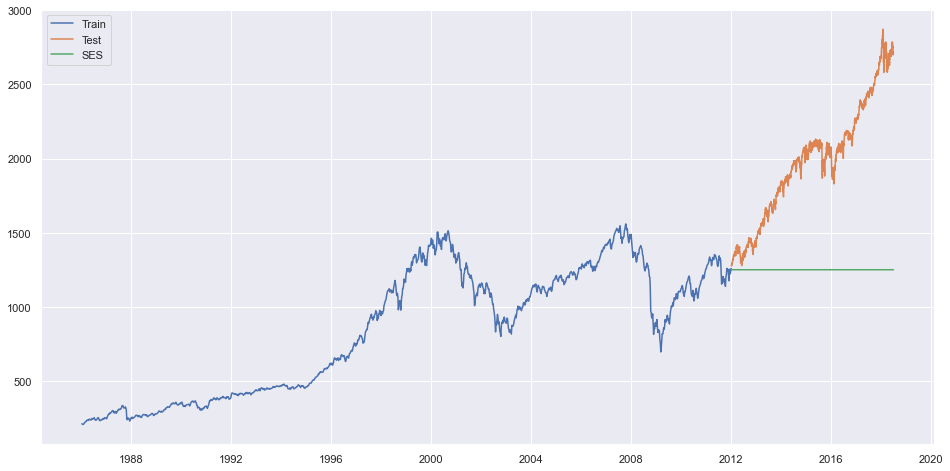

In [12]:
y_hat_avg = df_test.copy()
fit2 = SimpleExpSmoothing(np.asarray(df_train_2['close'])).fit(smoothing_level=0.6,optimized=False)
y_hat_avg['SES'] = fit2.forecast(len(df_test))
plt.figure(figsize=(16,8))
plt.plot(df_train_2['close'], label='Train')
plt.plot(df_test['close'], label='Test')
plt.plot(y_hat_avg['SES'], label='SES')
plt.legend(loc='best')
plt.show()

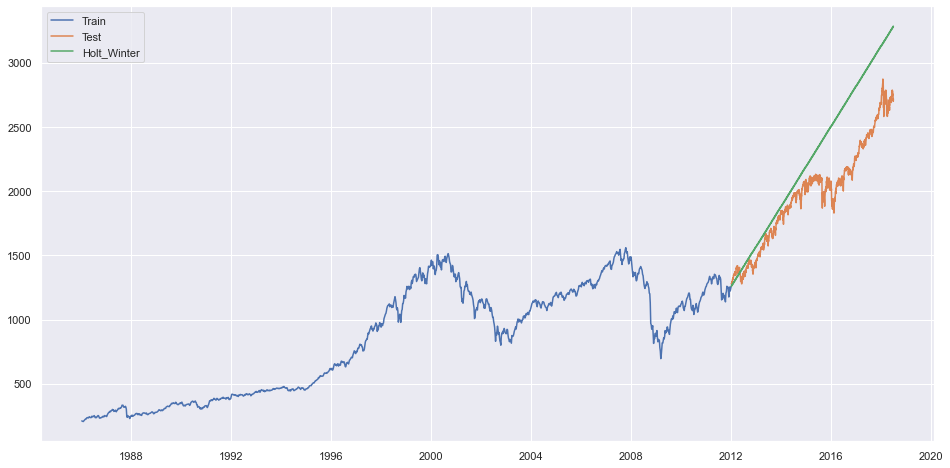

In [24]:
y_hat_avg = df_test.copy()
fit1 = ExponentialSmoothing(np.asarray(df_train_2['close']) ,seasonal_periods=6,trend='add', seasonal='add',).fit()
y_hat_avg['Holt_Winter'] = fit1.forecast(len(df_test))
plt.figure(figsize=(16,8))
plt.plot(df_train_2['close'], label='Train')
plt.plot(df_test['close'], label='Test')
plt.plot(y_hat_avg['Holt_Winter'], label='Holt_Winter')
plt.legend(loc='best')
plt.show()

# Extras

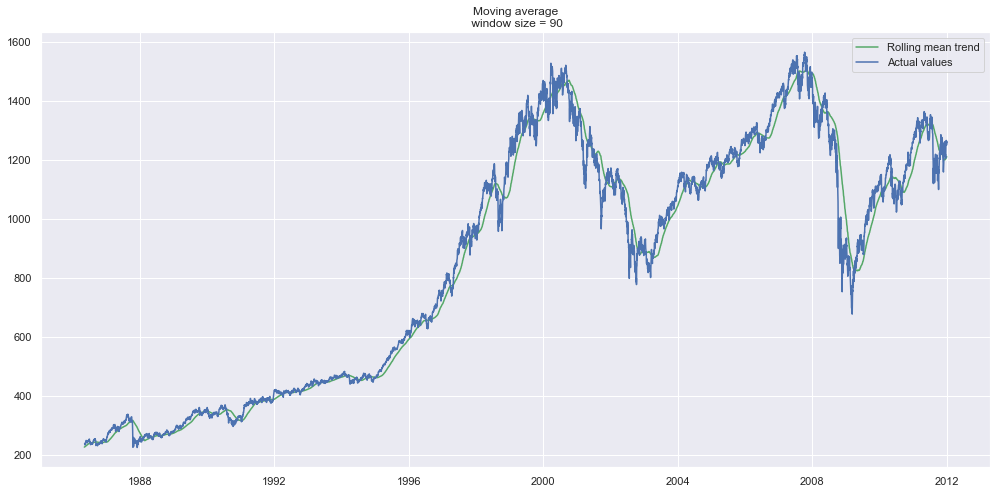

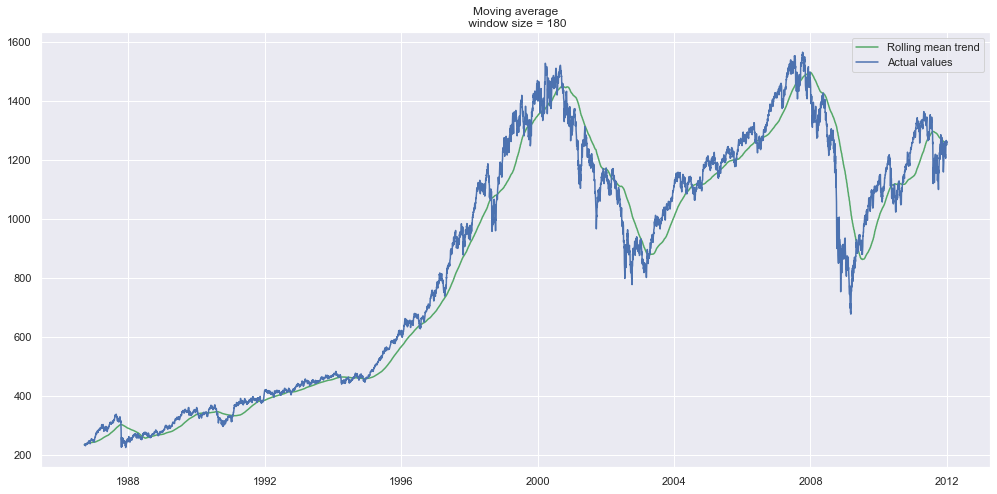

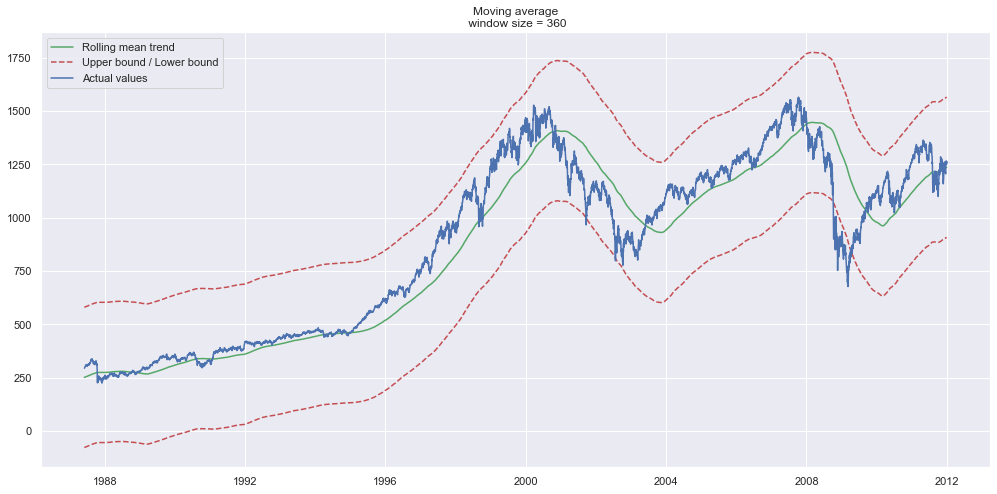

In [14]:
#Smooth by the previous 3 months (90 days)
plot_moving_average(df_train.close, 90)

#Smooth by the previous 6 month (180 days)
plot_moving_average(df_train.close, 180)

#Smooth by previous one year (360 days)
plot_moving_average(df_train.close, 360, plot_intervals=True)

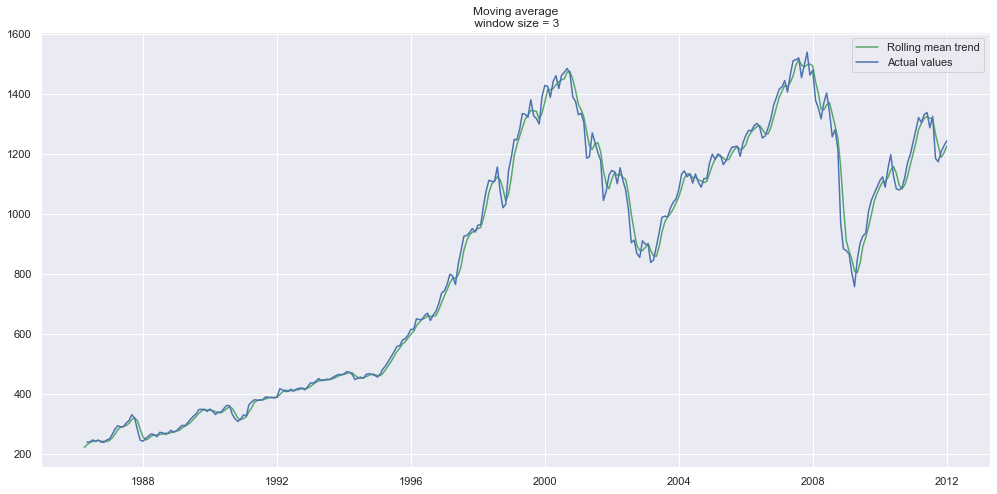

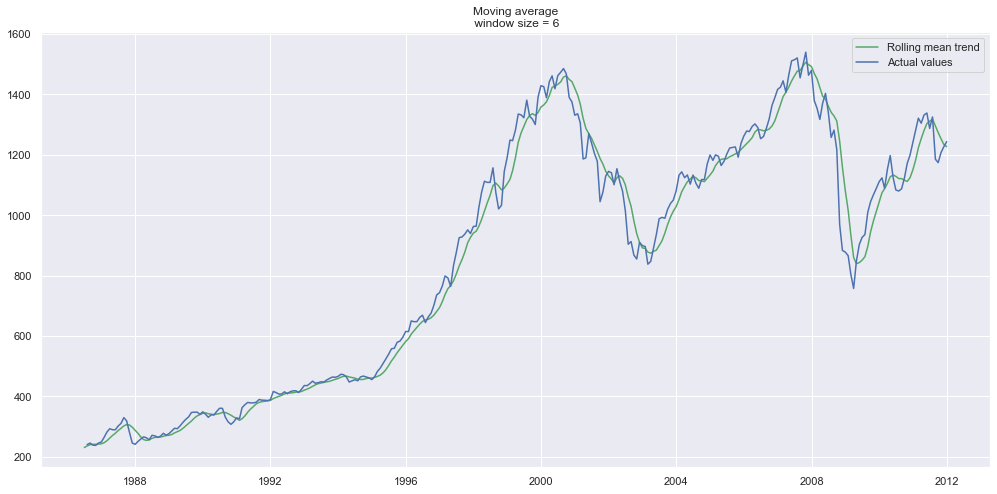

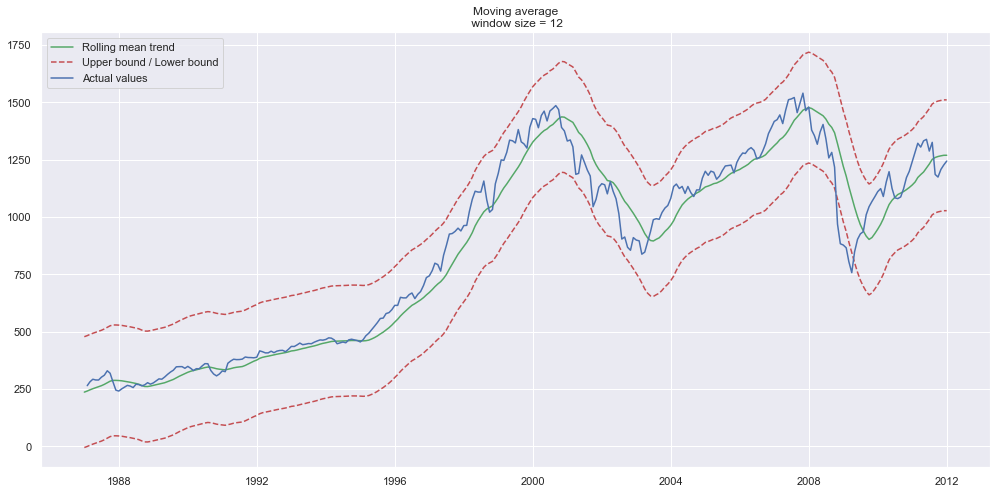

In [15]:
#Smooth by the previous 3 months (12 weeks)
plot_moving_average(df_train_month.close, 3)

#Smooth by the previous 6 month (24 weeks)
plot_moving_average(df_train_month.close, 6)

#Smooth by previous one year (48 weeks)
plot_moving_average(df_train_month.close, 12, plot_intervals=True)

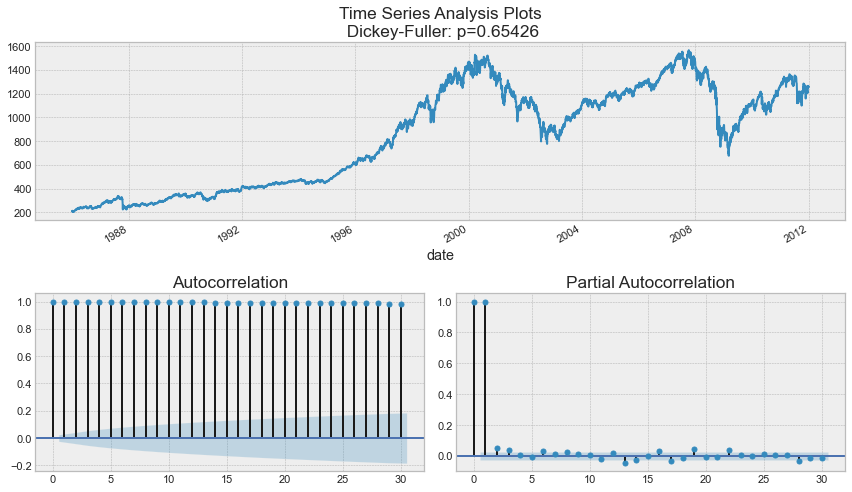

In [16]:
tsplot(df_train.close, lags=30)

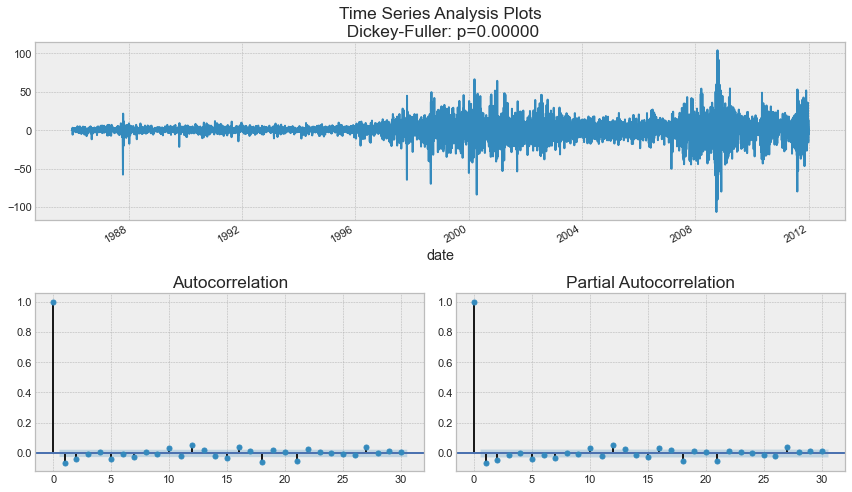

In [17]:
data_diff = df_train.close - df_train.close.shift(1)

tsplot(data_diff[1:], lags=30)

In [18]:
#p_value2 = sm.tsa.stattools.kpss(df_train.close,nlags='legacy')[1]
#p_value2